# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022  
  
This is a code supporting the corresponding paper.

Packages import:

In [1]:
import os
import numpy as np
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import pandas as pd

import albumentations as A

import SimpleITK as sitk

plt.style.use("ggplot")

Using TensorFlow backend.
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


GPU assignment:

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1,4'                        
import tensorflow as tf
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

W1011 13:44:33.602886 28200 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1011 13:44:33.602886 28200 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1011 13:44:33.602886 28200 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1011 13:44:51.147215 28200 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [3]:
import nibabel as nib
import pickle

## 1. Data load

In [398]:
sub_names_train = ['AMC008', 'AMC003', 'AMC011', 'AMC010', 'AMC014', 'AMC013', 'AMC002', 'AMC001', 'AMC018',  
                   'MUMC084', 'MUMC072', 'MUMC002', 'MUMC030', 'MUMC065', 'MUMC010', 'MUMC031', 'MUMC037', 'MUMC111', 
                   'MUMC009', 'MUMC013', 'MUMC033', 'MUMC056', 'MUMC082', 'MUMC035', 'MUMC119', 'MUMC040', 'MUMC118', 
                   'MUMC089', 'MUMC060', 'MUMC074', 'MUMC011', 'MUMC048', 'MUMC120', 'MUMC077', 'MUMC044', 'MUMC068', 
                   'MUMC001', 'MUMC125', 'MUMC105', 'MUMC055', 'MUMC098', 'MUMC073', 'MUMC026', 'MUMC099', 'MUMC101', 
                   'MUMC075', 'MUMC100', 'MUMC076', 'MUMC121', 'MUMC050', 'MUMC061', 'MUMC092', 'MUMC017', 'MUMC109', 
                   'MUMC091', 'MUMC129', 'MUMC016', 'MUMC067', 'MUMC045', 'MUMC096', 'MUMC028', 'MUMC020', 'MUMC095', 
                   'MUMC003', 'MUMC117', 'MUMC106', 'MUMC122', 'MUMC019', 'MUMC085', 'MUMC046', 'MUMC116', 'MUMC057', 
                   'MUMC090', 'MUMC110', 'MUMC024', 'MUMC015', 'MUMC032', 'MUMC039', 'MUMC049', 'MUMC063', 'MUMC021', 
                   'MUMC029', 'MUMC023', 'MUMC104', 'MUMC066', 'MUMC058', 'MUMC128', 'MUMC053', 'MUMC108', 
                   'UMCU016', 'UMCU039', 'UMCU001', 'UMCU027', 'UMCU020', 'UMCU009', 'UMCU030', 'UMCU024', 'UMCU002', 
                   'UMCU022', 'UMCU035', 'UMCU033', 'UMCU038', 'UMCU037', 'UMCU032', 'UMCU031', 'UMCU026']
sub_names_valid = ['AMC005', 'AMC007', 
                   'MUMC123', 'MUMC025', 'MUMC041', 'MUMC124', 'MUMC113', 'MUMC081', 'MUMC103', 'MUMC006', 'MUMC112', 
                   'MUMC051', 'MUMC008', 'MUMC126', 'MUMC088', 'MUMC097', 'MUMC047', 'MUMC014', 'MUMC078', 
                   'UMCU010', 'UMCU023', 'UMCU017', 'UMCU012']
sub_names_test = ['AMC012', 'AMC006', 
                  'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038', 'MUMC093', 'MUMC107', 
                  'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 'MUMC059', 'MUMC080', 
                  'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [401]:
dirname_imgdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTr/'
dirname_imgdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTs1/'
dirname_gtdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTr/'
dirname_gtdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTs1/'
dirname_nnunetdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Tr/'
dirname_nnunetdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Ts1/'

In [424]:
n_samples_train = 0

for sub_name in sub_names_train:
    
    filename_img = dirname_imgdata + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunetdata + sub_name + '.npz'
    filename_pkl = dirname_nnunetdata + sub_name + '.pkl'
    filename_gt = dirname_gtdata + sub_name + '.nii.gz'
    
    img = nib.load(filename_img).get_fdata().T
    n_samples_train += img.shape[0]
    
n_samples_train

1539

In [425]:
n_samples_valid = 0

for sub_name in sub_names_valid:
    
    filename_img = dirname_imgdata + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunetdata + sub_name + '.npz'
    filename_pkl = dirname_nnunetdata + sub_name + '.pkl'
    filename_gt = dirname_gtdata + sub_name + '.nii.gz'
    
    img = nib.load(filename_img).get_fdata().T
    n_samples_valid += img.shape[0]
    
n_samples_valid

339

In [426]:
n_samples_test = 0

for sub_name in sub_names_test:
    
    filename_img = dirname_imgdata_test + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunetdata_test + sub_name + '.npz'
    filename_pkl = dirname_nnunetdata_test + sub_name + '.pkl'
    filename_gt = dirname_gtdata_test + sub_name + '.nii.gz'
    
    img = nib.load(filename_img).get_fdata().T
    n_samples_test += img.shape[0]
    
n_samples_test

350

In [427]:
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_SIDE = 64
IMG_SIDE_LARGE = 128

In [428]:
def generate_crop(gt_xmin, gt_xmax, gt_ymin, gt_ymax, im_side=IMG_SIDE, rs=0):
    
    random.seed(rs)
        
    side_x = gt_xmax - gt_xmin
    side_y = gt_ymax - gt_ymin
    
    crop_xmin = max(0, gt_xmin-random.randint(2, max(2, IMG_SIDE_LARGE-side_x)))
    crop_ymin = max(0, gt_ymin-random.randint(2, max(2, IMG_SIDE_LARGE-side_y)))
    
    crop_xmax = crop_xmin + im_side
    crop_ymax = crop_ymin + im_side
    
    if crop_xmax>IMG_HEIGHT-1:
        crop_xmax=IMG_HEIGHT
        crop_xmin=crop_xmax-im_side
        
    if crop_ymax>IMG_WIDTH-1:
        crop_ymax=IMG_WIDTH
        crop_ymin=crop_ymax-im_side

    crop = [crop_xmin, crop_xmax, crop_ymin, crop_ymax]
    
    return crop

In [429]:
def norm_crop(img_arr, gt_arr, n_crops = 5):

    img_min = np.min(img_arr) 
    img_max = np.max(img_arr) 
    
    img_norm = np.copy((img_arr - img_min)/(img_max - img_min)*255).astype(np.uint8)

    gt_xmin = np.min(np.where(gt_arr > 0)[0])
    gt_xmax = np.max(np.where(gt_arr > 0)[0])
    gt_ymin = np.min(np.where(gt_arr > 0)[1])
    gt_ymax = np.max(np.where(gt_arr > 0)[1])
    
    crops = []
    for i in range(0, n_crops):
        crop = generate_crop(gt_xmin, gt_xmax, gt_ymin, gt_ymax, rs=i)
        crops.append(crop)
        
    return img_norm, crops
    

In [430]:
def fill_arrays(X, y, sub_names, dirname_img, dirname_nnunet, dirname_gt, n_crops = 5):
    
    i = 0

    for sub_name in sub_names:
       

        filename_img = dirname_img + sub_name + '_0000.nii.gz'
        filename_sm = dirname_nnunet + sub_name + '.npz'
        filename_pkl = dirname_nnunet + sub_name + '.pkl'
        filename_gt = dirname_gt + sub_name + '.nii.gz'

        img = nib.load(filename_img).get_fdata().T
        gt = nib.load(filename_gt).get_fdata().T
        sm_cropped = np.load(filename_sm)['softmax']
        with open(filename_pkl, 'rb') as f:
            p = pickle.load(f)
        crop_box = p['crop_bbox']
        sm = np.zeros(img.shape, dtype=np.float16)
        sm[crop_box[0][0]:crop_box[0][1], crop_box[1][0]:crop_box[1][1], crop_box[2][0]:crop_box[2][1]] = sm_cropped[1, ...]

        for j in range (0, img.shape[0]):
            img_norm, crops = norm_crop(img[j, ...], gt[j, ...], n_crops)
            for crop in crops:
                img_norm_crop = np.copy(img_norm[crop[0]:crop[1], crop[2]:crop[3]])
                gt_crop = np.copy(gt[j, crop[0]:crop[1], crop[2]:crop[3]])
                sm_crop = np.copy(255*sm[j, crop[0]:crop[1], crop[2]:crop[3]])
                X[i, ..., 0] = img_norm_crop
                X[i, ..., 1] = sm_crop
                y[i, ..., 0] = gt_crop
                i += 1
                
    return None
    

In [431]:
X_train = np.zeros((n_samples_train*5, IMG_SIDE, IMG_SIDE, 2), dtype = np.uint8)
y_train = np.zeros((n_samples_train*5, IMG_SIDE, IMG_SIDE, 1), dtype = np.uint8)

X_valid = np.zeros((n_samples_valid*5, IMG_SIDE, IMG_SIDE, 2), dtype = np.uint8)
y_valid = np.zeros((n_samples_valid*5, IMG_SIDE, IMG_SIDE, 1), dtype = np.uint8)

In [432]:
X_test = np.zeros((n_samples_test, IMG_SIDE, IMG_SIDE, 2), dtype = np.uint8)
y_test = np.zeros((n_samples_test, IMG_SIDE, IMG_SIDE, 1), dtype = np.uint8)

In [433]:
fill_arrays(X_train, y_train, sub_names_train, dirname_imgdata, dirname_nnunetdata, dirname_gtdata)
fill_arrays(X_valid, y_valid, sub_names_valid, dirname_imgdata, dirname_nnunetdata, dirname_gtdata)

In [434]:
fill_arrays(X_test, y_test, sub_names_test, dirname_imgdata_test, dirname_nnunetdata_test, dirname_gtdata_test, n_crops=1)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  


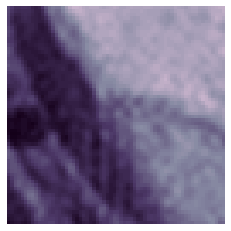

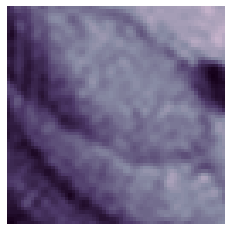

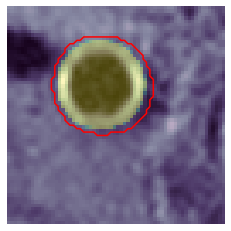

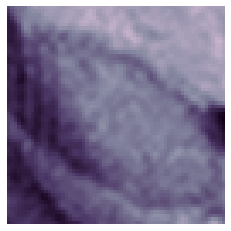

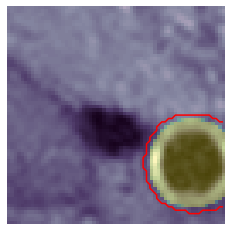

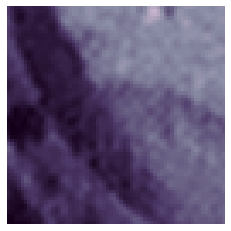

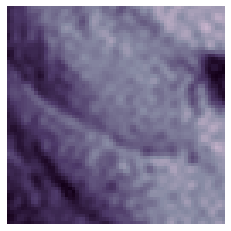

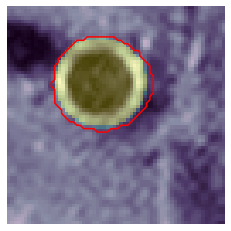

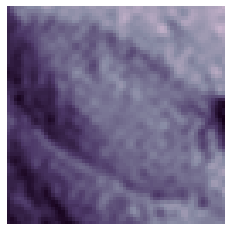

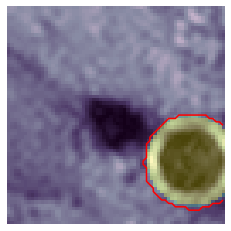

In [435]:
# visualization of the training patches

for i in range (145, 155):
    plt.imshow(X_train[i, ..., 0], cmap = 'bone')
    plt.imshow(X_train[i, ..., 1], alpha = 0.3)
    plt.contour(y_train[i, ..., 0], colors='r', levels=[0.5])
    plt.axis('Off')
    plt.show()

In [444]:
#for i in range (145, 155):
#    plt.imshow(X_test[i, ..., 0], cmap = 'bone')
#    plt.imshow(X_test[i, ..., 1], alpha = 0.3)
#    plt.contour(y_test[i, ..., 0], colors='r', levels=[0.5])
#    plt.axis('Off')
#    plt.show()

## 2. Data augmentation

Defining transformations:

In [436]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedCrop(min_max_height=(48, 64), height=64, width=64, p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.RandomGamma(p=0.5)
])

Generation of the augmented patches:

In [437]:
# n_augms random transformations of the images X and masks y

def augment_ds(X, y, n_augms):
    
    counter = 0
    dim = y[0, ..., 0].shape
    n_samples = y.shape[0]
    
    X_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 2), dtype = np.uint8)
    y_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    
    for smpl in range (0, n_samples):
        for augm in range (0, n_augms):

            random.seed(counter)
            augmented = transform(image=X[smpl, ..., 0], mask=y[smpl, ..., 0])
            X_aug[counter, ..., 0] = augmented['image']
            y_aug[counter, ..., 0] = augmented['mask']
            random.seed(counter)
            augmented = transform(image=X[smpl, ..., 0], mask=X[smpl, ..., 1])
            X_aug[counter, ..., 1] = augmented['mask']
            counter += 1
            
    return X_aug, y_aug    

Writing augmented data into arrays:

In [438]:
X_train_aug, y_train_aug = augment_ds(X_train, y_train, 10)
X_valid_aug, y_valid_aug = augment_ds(X_valid, y_valid, 10)

Visualization of the transformed images:

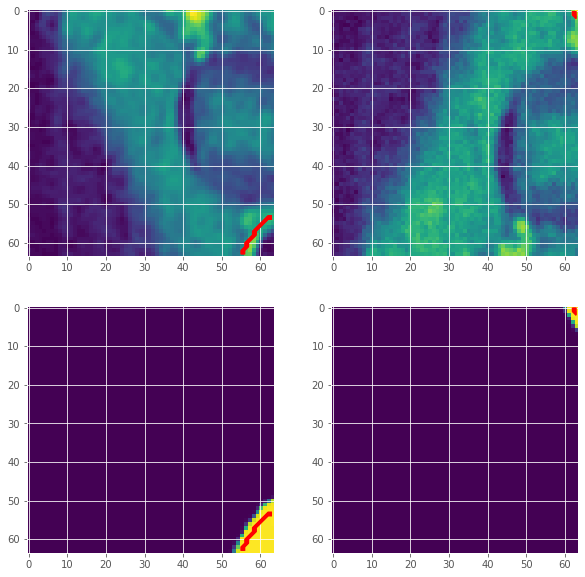

In [439]:
n_sample = 150

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(X_train[n_sample//10, ..., 0])
plt.contour(y_train[n_sample//10, ..., 0], colors='r')
plt.subplot(222)
plt.imshow(X_train_aug[n_sample, ..., 0])
plt.contour(y_train_aug[n_sample, ..., 0], colors='r')
plt.subplot(223)
plt.imshow(X_train[n_sample//10, ..., 1], vmin=0, vmax=255)
plt.contour(y_train[n_sample//10, ..., 0], colors='r')
plt.subplot(224)
plt.imshow(X_train_aug[n_sample, ..., 1], vmin=0, vmax=255)
plt.contour(y_train_aug[n_sample, ..., 0], colors='r')
plt.show()

## 3. U-Net construction

Defining blocks:

In [440]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 8, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Custom scores:

In [441]:
def dice_coef(y_true, y_pred):
    from keras import backend as K
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def custom_loss(y_true, y_pred):
    from keras.losses import binary_crossentropy
    return 0.5*keras.losses.binary_crossentropy(y_true,y_pred)+0.5*dice_loss(y_true,y_pred)

Model compilation:

In [442]:
input_img = Input((IMG_SIDE, IMG_SIDE, 2), name='img')

model_simple = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_simple.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy', dice_coef])
model_simple.summary()

model_aug = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_aug.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy', dice_coef])
model_aug.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 64, 64, 16)   304         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 64, 64, 16)   64          conv2d_116[0][0]                 
__________________________________________________________________________________________________
activation_110 (Activation)     (None, 64, 64, 16)   0           batch_normalization_110[0][0]    
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 64, 64, 16)   304         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_128 (BatchN (None, 64, 64, 16)   64          conv2d_135[0][0]                 
__________________________________________________________________________________________________
activation_128 (Activation)     (None, 64, 64, 16)   0           batch_normalization_128[0][0]    
__________________________________________________________________________________________________
max_poolin

Callbacks:

In [443]:
callbacks_simple = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../res/plaq-u-net_simple_dce_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

callbacks_aug = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../res/plaq-u-net_aug_dce_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## 4. Model training with and without augmentation

Models training (with and w/o augmentation):

In [445]:
# simple model (w/o data augmentation)

results_simple = model_simple.fit(X_train, y_train,
                                  batch_size=64, epochs=100, 
                                  callbacks=callbacks_simple, 
                                  validation_data=(X_valid, y_valid))

Train on 7695 samples, validate on 1695 samples
Epoch 1/100
7695/7695 [==============================] - 16s 2ms/step - loss: 0.6441 - acc: 0.9257 - dice_coef: 0.3559 - val_loss: 0.5674 - val_acc: 0.9829 - val_dice_coef: 0.4326

Epoch 00001: val_loss improved from inf to 0.56737, saving model to ../res/plaq-u-net_simple_dce_1.h5
Epoch 2/100
7695/7695 [==============================] - 6s 787us/step - loss: 0.4057 - acc: 0.9906 - dice_coef: 0.5943 - val_loss: 0.2920 - val_acc: 0.9884 - val_dice_coef: 0.7080

Epoch 00002: val_loss improved from 0.56737 to 0.29203, saving model to ../res/plaq-u-net_simple_dce_1.h5
Epoch 3/100
7695/7695 [==============================] - 6s 793us/step - loss: 0.1992 - acc: 0.9928 - dice_coef: 0.8008 - val_loss: 0.1572 - val_acc: 0.9886 - val_dice_coef: 0.8428

Epoch 00003: val_loss improved from 0.29203 to 0.15723, saving model to ../res/plaq-u-net_simple_dce_1.h5
Epoch 4/100
7695/7695 [==============================] - 7s 868us/step - loss: 0.1109 - acc: 

7695/7695 [==============================] - 7s 850us/step - loss: 0.0385 - acc: 0.9948 - dice_coef: 0.9615 - val_loss: 0.0745 - val_acc: 0.9895 - val_dice_coef: 0.9255

Epoch 00032: val_loss did not improve from 0.07413
Epoch 33/100
7695/7695 [==============================] - 6s 837us/step - loss: 0.0386 - acc: 0.9948 - dice_coef: 0.9614 - val_loss: 0.0746 - val_acc: 0.9895 - val_dice_coef: 0.9254

Epoch 00033: val_loss did not improve from 0.07413
Epoch 34/100
7695/7695 [==============================] - 7s 853us/step - loss: 0.0384 - acc: 0.9948 - dice_coef: 0.9616 - val_loss: 0.0745 - val_acc: 0.9895 - val_dice_coef: 0.9255

Epoch 00034: val_loss did not improve from 0.07413
Epoch 35/100
7695/7695 [==============================] - 7s 893us/step - loss: 0.0386 - acc: 0.9948 - dice_coef: 0.9614 - val_loss: 0.0746 - val_acc: 0.9895 - val_dice_coef: 0.9254

Epoch 00035: val_loss did not improve from 0.07413
Epoch 36/100
7695/7695 [==============================] - 7s 896us/step - los

7695/7695 [==============================] - 6s 827us/step - loss: 0.0370 - acc: 0.9950 - dice_coef: 0.9630 - val_loss: 0.0745 - val_acc: 0.9894 - val_dice_coef: 0.9255

Epoch 00067: val_loss did not improve from 0.07413
Epoch 68/100
7695/7695 [==============================] - 6s 820us/step - loss: 0.0370 - acc: 0.9949 - dice_coef: 0.9630 - val_loss: 0.0743 - val_acc: 0.9894 - val_dice_coef: 0.9257

Epoch 00068: val_loss did not improve from 0.07413
Epoch 69/100
7695/7695 [==============================] - 7s 901us/step - loss: 0.0370 - acc: 0.9949 - dice_coef: 0.9630 - val_loss: 0.0743 - val_acc: 0.9894 - val_dice_coef: 0.9257

Epoch 00069: val_loss did not improve from 0.07413
Epoch 70/100
7695/7695 [==============================] - 7s 857us/step - loss: 0.0369 - acc: 0.9950 - dice_coef: 0.9631 - val_loss: 0.0743 - val_acc: 0.9894 - val_dice_coef: 0.9257

Epoch 00070: val_loss did not improve from 0.07413
Epoch 71/100
7695/7695 [==============================] - 7s 877us/step - los

In [446]:
# data augmentation

results_aug = model_aug.fit(X_train_aug, y_train_aug,
                            batch_size=64, epochs=100, 
                            callbacks=callbacks_aug, 
                            validation_data=(X_valid_aug, y_valid_aug))

Train on 76950 samples, validate on 16950 samples
Epoch 1/100
76950/76950 [==============================] - 75s 980us/step - loss: 0.1240 - acc: 0.9899 - dice_coef: 0.8760 - val_loss: 0.1093 - val_acc: 0.9862 - val_dice_coef: 0.8907

Epoch 00001: val_loss improved from inf to 0.10925, saving model to ../res/plaq-u-net_aug_dce_1.h5
Epoch 2/100
76950/76950 [==============================] - 66s 856us/step - loss: 0.0573 - acc: 0.9914 - dice_coef: 0.9427 - val_loss: 0.1021 - val_acc: 0.9870 - val_dice_coef: 0.8979

Epoch 00002: val_loss improved from 0.10925 to 0.10209, saving model to ../res/plaq-u-net_aug_dce_1.h5
Epoch 3/100
76950/76950 [==============================] - 68s 880us/step - loss: 0.0546 - acc: 0.9917 - dice_coef: 0.9454 - val_loss: 0.1014 - val_acc: 0.9868 - val_dice_coef: 0.8986

Epoch 00003: val_loss improved from 0.10209 to 0.10137, saving model to ../res/plaq-u-net_aug_dce_1.h5
Epoch 4/100
76950/76950 [==============================] - 67s 865us/step - loss: 0.0530 -

76950/76950 [==============================] - 67s 870us/step - loss: 0.0451 - acc: 0.9930 - dice_coef: 0.9549 - val_loss: 0.0967 - val_acc: 0.9872 - val_dice_coef: 0.9033

Epoch 00032: val_loss did not improve from 0.09537
Epoch 33/100
76950/76950 [==============================] - 68s 887us/step - loss: 0.0449 - acc: 0.9931 - dice_coef: 0.9551 - val_loss: 0.0966 - val_acc: 0.9872 - val_dice_coef: 0.9034

Epoch 00033: val_loss did not improve from 0.09537
Epoch 34/100
76950/76950 [==============================] - 67s 875us/step - loss: 0.0449 - acc: 0.9931 - dice_coef: 0.9551 - val_loss: 0.0969 - val_acc: 0.9872 - val_dice_coef: 0.9031

Epoch 00034: val_loss did not improve from 0.09537
Epoch 35/100
76950/76950 [==============================] - 69s 895us/step - loss: 0.0449 - acc: 0.9931 - dice_coef: 0.9551 - val_loss: 0.0966 - val_acc: 0.9872 - val_dice_coef: 0.9034

Epoch 00035: val_loss did not improve from 0.09537
Epoch 36/100
76950/76950 [==============================] - 69s 8

76950/76950 [==============================] - 69s 890us/step - loss: 0.0441 - acc: 0.9932 - dice_coef: 0.9559 - val_loss: 0.0964 - val_acc: 0.9872 - val_dice_coef: 0.9036

Epoch 00066: val_loss did not improve from 0.09537
Epoch 67/100
76950/76950 [==============================] - 69s 897us/step - loss: 0.0442 - acc: 0.9932 - dice_coef: 0.9558 - val_loss: 0.0964 - val_acc: 0.9872 - val_dice_coef: 0.9036

Epoch 00067: val_loss did not improve from 0.09537
Epoch 68/100
76950/76950 [==============================] - 66s 863us/step - loss: 0.0442 - acc: 0.9932 - dice_coef: 0.9558 - val_loss: 0.0966 - val_acc: 0.9872 - val_dice_coef: 0.9034

Epoch 00068: val_loss did not improve from 0.09537
Epoch 69/100
76950/76950 [==============================] - 68s 885us/step - loss: 0.0440 - acc: 0.9932 - dice_coef: 0.9560 - val_loss: 0.0964 - val_acc: 0.9871 - val_dice_coef: 0.9036

Epoch 00069: val_loss did not improve from 0.09537
Epoch 70/100
76950/76950 [==============================] - 69s 8

76950/76950 [==============================] - 67s 867us/step - loss: 0.0433 - acc: 0.9933 - dice_coef: 0.9567 - val_loss: 0.0967 - val_acc: 0.9871 - val_dice_coef: 0.9033

Epoch 00100: val_loss did not improve from 0.09537


Learning curves visualization:

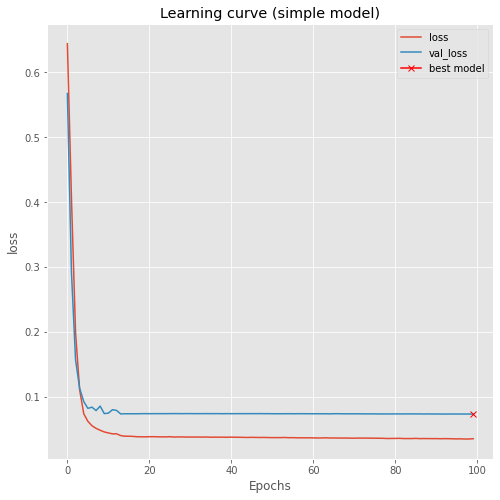

In [447]:
# simple model

plt.figure(figsize=(8, 8))
plt.title("Learning curve (simple model)")
plt.plot(results_simple.history["loss"], label="loss")
plt.plot(results_simple.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_simple.history["val_loss"]), np.min(results_simple.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

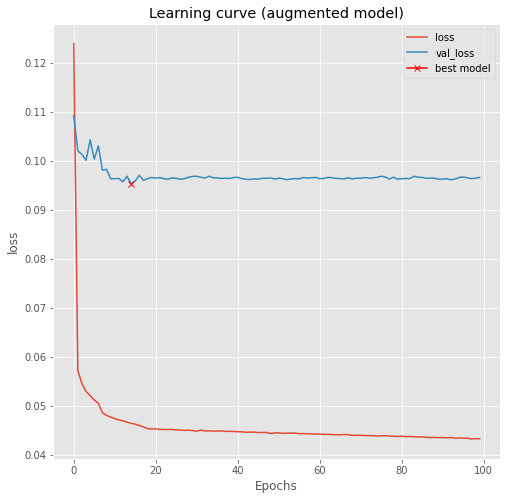

In [448]:
# augmented model

plt.figure(figsize=(8, 8))
plt.title("Learning curve (augmented model)")
plt.plot(results_aug.history["loss"], label="loss")
plt.plot(results_aug.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_aug.history["val_loss"]), np.min(results_aug.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

## 5. Models performance on patches

Loading weights:

In [411]:
model_simple.load_weights('../res/plaq-u-net_simple_dce.h5')
model_aug.load_weights('../res/plaq-u-net_aug_dce.h5')

Evaluating on the PATCHES of the validation set:

In [412]:
# simple model

model_simple.evaluate(X_valid, y_valid, verbose=1)

1695/1695 [==============================] - 1s 435us/step


[0.08477280871354725, 0.9681693916827177, 0.9152271915677727]

In [413]:
# augmented model:

model_aug.evaluate(X_valid, y_valid, verbose=1)

1695/1695 [==============================] - 1s 411us/step


[0.08296089073901332, 0.9672700323889741, 0.9170391086983469]

Evaluation on the PATCHES of the test set:

In [414]:
# simple model

model_simple.evaluate(X_test, y_test, verbose=1)

350/350 [==============================] - 1s 2ms/step


[0.08064209154673985, 0.9690876112665449, 0.9193579084532602]

In [415]:
# augmented model

model_aug.evaluate(X_test, y_test, verbose=1)

350/350 [==============================] - 0s 480us/step


[0.09418484006609236, 0.9630894255638123, 0.9058151599339076]

Predictions for the test set (+ thresholding):

In [416]:
preds_test_simple = model_simple.predict(X_test, verbose=1)
preds_test_simple_t = (preds_test_simple > 0.5).astype(np.uint8)

preds_test_aug = model_aug.predict(X_test, verbose=1)
preds_test_aug_t = (preds_test_aug > 0.5).astype(np.uint8)

350/350 [==============================] - 2s 5ms/step


Visualization of the prediction:

In [417]:
from matplotlib.patches import Patch
import matplotlib.font_manager as font_manager

In [418]:
font = font_manager.FontProperties(family='Times New Roman', weight='ultralight', size='12')

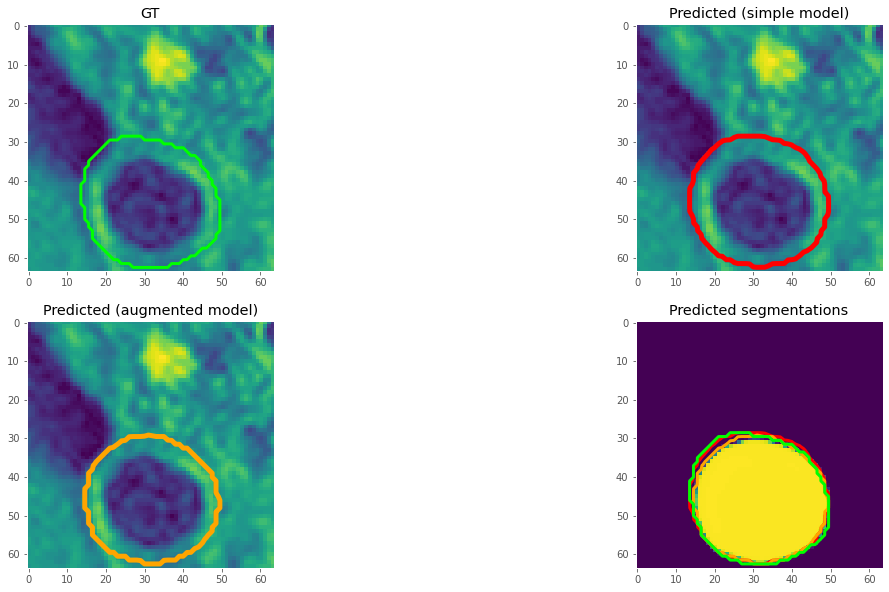

In [423]:
ix = 90

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0,0].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[0,0].contour(y_test[ix].squeeze(), colors='lime', levels=[0.5], linewidths=3)
ax[0,0].set_title('GT')
ax[0,0].grid(False)

ax[0,1].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[0,1].contour(preds_test_simple[ix].squeeze(), colors='r', levels=[0.5], linewidths=5)
ax[0,1].set_title('Predicted (simple model)')
ax[0,1].grid(False)

ax[1,0].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[1,0].contour(preds_test_aug[ix].squeeze(), colors='orange', levels=[0.5], linewidths=5)
ax[1,0].set_title('Predicted (augmented model)')
ax[1,0].grid(False)

ax[1,1].imshow(X_test[ix, ..., 1].squeeze())
ax[1,1].contour(preds_test_simple[ix].squeeze(), colors='r', levels=[0.5], linewidths=3)
ax[1,1].contour(preds_test_aug[ix].squeeze(), colors='orange', levels=[0.5], linewidths=3)
ax[1,1].contour(y_test[ix].squeeze(), colors='lime', levels=[0.5], linewidths=3)
ax[1,1].set_title('Predicted segmentations')
#legend_elements = [Patch(facecolor='red', label='Groundtruth'),
#                   Patch(facecolor='yellow', label='Autosegmentation')]
#ax[1,1].legend(handles=legend_elements, loc=4, prop=font)
ax[1,1].grid(False)